## SGD for FM [STEFFEN RENDLE]
* 目标函数
$$\hat{y} = w_0 + \sum_{j=1}^{p}w_jx_j+\frac{1}{2}\sum_{f=1}^{k}[(\sum_{j=1}^{p}v_{j,f}x_j)^2-\sum_{j=1}^{p}v_{j,f}^2x_j^2]$$

* 加入正则项，防止过拟合
* Algorithm for SGD
![](img_fm/3.png)
* Gridents
$$\frac{\partial}{\partial\theta}l^{LS}(\hat{y}(\vec{x}|\vec{\theta},y)) = \frac{\partial}{\partial\theta}(\hat{y}(\vec{x}|\vec{\theta})-y)^2 = 2(\hat{y}(\vec{x}|\vec{\theta})-y)\frac{\partial}{\partial\theta}\hat{y}(\vec{x}|\vec{\theta})$$
![](img_fm/4.png)

* Little tip for Numpy and sparse matrix
> numpy's dot function does not have native support for handling sparse matrices. What is happening is numpy thinks of the sparse matrix C as a python object

### load data

In [21]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import math
import matplotlib.pyplot as plt
# Read in data
def loadData(filename,path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user,movieid,rating,ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)

### 使用SGD训练FM

In [33]:
# -*- coding: utf-8 -*-
import numpy as np
import math


class FM_SGD:
    def __init__(self,
                 iter_num,
                 learning_rate,
                 factors_num,
                 reg_w,
                 reg_v,
                 verbose=True):

        # 迭代次数
        self.iter_num = iter_num

        # 学习速率
        self.learning_rate = learning_rate

        # 分解器feature个数
        self.factors_num = factors_num

        # lambda
        self.reg_w = reg_w

        self.reg_v = reg_v

        # 输出执行信息
        self.verbose = verbose

        # global bias
        self.w0 = 0

        # feature bias
        self.W = 0

        # feature
        self.V = 0

        # 训练过程中的mse
        self.mse = []

        # target y的最大值与最小值，for prune
        self.y_max = 0.0
        self.y_min = 0.0

    def train(self, X_, y_):

        (n, p) = X_.shape

        self.mse = []

        # global bias
        self.w0 = np.sum(np.random.rand(1, 1))  # bias

        # feature bias
        self.W = np.random.rand(1, p)

        # feature
        self.V = np.random.rand(p, self.factors_num)

        self.y_max = np.max(y_)
        self.y_min = np.min(y_)

        for j in xrange(self.iter_num):

            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx, :]
            y_train = y_[reidx]

            for i in xrange(n):

                if self.verbose and i % 10000 == 0:
                    print 'processing ' + str(i) + 'th sample...'

                X = X_train[i, :]
                y = y_train[i]

                # too slow
                #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                X = X.toarray()

                tmp = np.sum(X.T * self.V, axis=0)
                factor_part = (np.sum(tmp * tmp) - np.sum(
                    (X.T*X.T)*(self.V * self.V))) / 2
                y_predict = self.w0 + np.sum(np.dot(self.W, X.T)) + factor_part

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict - y
                loss_sgd.append(math.pow(diff, 2))

                # update mse
                self.mse.append(sum(loss_sgd) / len(loss_sgd))

                # update w0
                self.w0 -= self.learning_rate * (2 * diff * 1 + 2*self.reg_w*self.w0)

                # update W
                self.W -= self.learning_rate * (2 * diff * X + 2*self.reg_w*self.W)

                # update V
                self.V -= self.learning_rate * (2 * diff * (
                    X.T * (np.dot(X, self.V) - X.T * self.V)) + 2 * self.reg_v * self.V)

    def validate(self, X_, y_):
        (n, p) = X_.shape

        mse = []
        loss_sgd = []

        for i in xrange(n):

            if self.verbose and i % 1000 == 0:
                print 'prossing ' + str(i) + 'th sample...'

            X = X_[i, :]
            y = y_[i]

            # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

            tmp = np.sum(X.T.multiply(self.V), axis=0)
            factor_part = (np.sum(np.multiply(tmp, tmp)) - np.sum(
                (X.T.multiply(X.T)).multiply(np.multiply(self.V, self.V)))) / 2
            y_predict = self.w0 + self.W * X.T + factor_part

            #                 print y_predict

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict - y
            loss_sgd.append(math.pow(diff, 2))

            # update mse
            mse.append(sum(loss_sgd) / len(loss_sgd))
        return mse

In [34]:
import time
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)

start = time.time()
fm_sgd = FM_SGD(iter_num=1,
               learning_rate=0.01,
               factors_num=10,
               reg_w=0.01,
               reg_v = 0.001)
fm_sgd.train(X_train,y_train)
print '---%s seconds---' %(time.time() - start)

processing 0th sample...
processing 10000th sample...
processing 20000th sample...
processing 30000th sample...
processing 40000th sample...
processing 50000th sample...
processing 60000th sample...
processing 70000th sample...
processing 80000th sample...
processing 90000th sample...
---161.618000031 seconds---


In [75]:
np.sum((X_test * fm_sgd.W.T + fm_sgd.w0 - y_test[:, np.newaxis])**2)/y_test.shape[0]

1.2845786899864464

In [70]:
y_test

(9430L,)

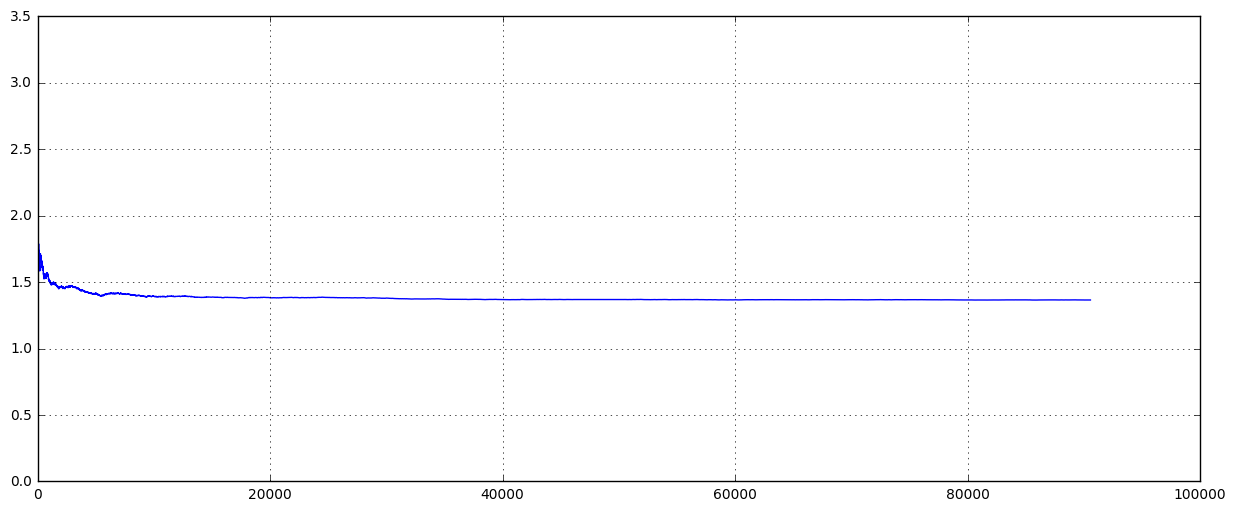

In [10]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_sgd.mse)

### 使用ADAGRAD 训练FM

* SGD的弊端在于使用了一个恒定的全局的学习速率，无法根据feature的gradient更新速率来动态调整更新学习速率
* 为了解决这一弊端，我们为每一个参数维护一个学习速率，随着迭代次数的增加，根据总的gradient来更新学习速率

In [ ]:
class FM_ADAGRAD():
    
    def __init__(self,
                iter_num,
                learning_rate,
                factors_num,
                reg,
                verbose = True):
        
        # 迭代次数
        self.iter_num = iter_num
        
        #学习速率
        self.learning_rate = learning_rate
        
        # 分解器feature个数
        self.factors_num = factors_num
        
        # lambda
        self.reg = reg
        
        # 输出执行信息
        self.verbose = verbose
        
        # global bias
        self.w0 = 0;
        
        # feature bias
        self.W = 0;
        
        # feature
        self.V = 0;
        
        # 训练过程中的mse
        self.mse = []
        
        # target y的最大值与最小值，for prune
        self.y_max = 0.0;
        self.y_min = 0.0;
        
        
    def train(self, X_, y_):
        
        (n,p) = X_.shape
        
        self.mse = []
        
        # global bias
        self.w0 = sum(np.random.rand(1))  # bias
        
        # feature bias
        self.W = np.random.rand(1,p)
        
        # feature
        self.V = np.random.rand(p,self.factors_num)
        
        self.y_max = np.max(y_)
        self.y_min = np.min(y_)
        
        # keep track of all parameters 
        w0_gradients = 0.0;
        W_gradients = np.zeros((1,p))
        V_gradients = np.zeros((p,self.factors_num))
        
        # avoid 0 numerator
        epison = 1e-8
        
        for j in xrange(self.iter_num):
            
            loss_sgd = []

            # shuffle
            reidx = np.random.permutation(n)
            X_train = X_[reidx,:]
            y_train = y_[reidx]

            

            for i in xrange(n):

                if self.verbose and i%1000 ==0:
                    print 'prossing ' + str(i) + 'th sample...'

                X = X_train[i,:]
                y = y_train[i]

                # too slow
            #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

                tmp = np.sum(X.T.multiply(self.V),axis=0)
                factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
                y_predict = self.w0 + np.sum(self.W*X.T) + factor_part
                
#                 print y_predict

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = y_predict-y
                loss_sgd.append(math.pow(diff,2))

                # update mse
                self.mse.append(sum(loss_sgd)/len(loss_sgd))

                # update w0
                gradient = 2*diff * (1)
                w0_gradients += np.square(gradient)
                self.w0 = self.w0 - self.learning_rate/np.sqrt(w0_gradients+epison)*gradient
                
                
                # update W
                gradient = 2*diff * (X)
                W_gradients += gradient.multiply(gradient)
                self.W = self.W - gradient.multiply(self.learning_rate/np.sqrt(W_gradients+epison))
                
#                 print W_gradients.shape
#                 print gradient.shape
                
                
                
                # update V
                gradient = 2*diff* (X.T.multiply((np.tile(X*self.V,(p,1)) - X.T.multiply(self.V))))
                V_gradients += np.multiply(gradient,gradient)
                self.V = self.V - np.multiply(self.learning_rate/np.sqrt(V_gradients+epison),gradient)
                

    def validate(self, X_, y_):
        (n,p) = X_.shape
        
        mse = []
        

        for i in xrange(n):

            if self.verbose and i%1000 ==0:
                print 'prossing ' + str(i) + 'th sample...'

            X = X_train[i,:]
            y = y_train[i]

            # too slow
        #     y_predict = (w0 + W*X.T + ((X.T*X).multiply((np.triu(V.dot(V.T),1)))).sum().sum())[0,0]

            tmp = np.sum(X.T.multiply(self.V),axis=0)
            factor_part = (np.sum(np.multiply(tmp,tmp)) - np.sum((X.T.multiply(X.T)).multiply(np.multiply(self.V,self.V))))/2
            y_predict = self.w0 + np.sum(self.W*X.T) + factor_part

#                 print y_predict

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = y_predict-y
            loss_sgd.append(math.pow(diff,2))

            # update mse
            mse.append(sum(loss_sgd)/len(loss_sgd))
        return mse

In [ ]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
fm_adagrad = FM_ADAGRAD(iter_num=1,
               learning_rate=0.1,
               factors_num=10,
               reg=0.1)
fm_adagrad.train(X_train,y_train)

In [ ]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(fm_adagrad.mse)

In [ ]:
fm_adagrad.W

## Local Linear Factorization Machines

In [79]:
# -*- coding: utf-8 -*-
import math

import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import time


class LLFM_SGD:
    def __init__(self,
                 iter_num,
                 learning_rate,
                 factors_num,
                 reg_w,
                 reg_v,
                 anchor_num,
                 neighbor_num,
                 verbose=True):

        # 迭代次数
        self.iter_num = iter_num

        # 学习速率
        self.learning_rate = learning_rate

        # 分解器feature个数
        self.factors_num = factors_num

        # lambda
        self.reg_w = reg_w

        self.reg_v = reg_v

        # 输出执行信息
        self.verbose = verbose

        # global bias
        self.w0 = np.array([0])

        # feature bias
        self.W = np.array([0])

        # feature
        self.V = np.array([0])

        # 训练过程中的mse
        self.mse = []

        # target y的最大值与最小值，for prune
        self.y_max = 0.0
        self.y_min = 0.0

        # anchor point 的个数
        self.anchor_num = anchor_num

        # find k-nearest anchor points
        self.neighbor_num = neighbor_num

        # anchor point
        self.anchor_points = np.array([0])

    def knn(self, x):
        dist = np.linalg.norm(self.anchor_points - x, axis=1)
        idx = np.argsort(dist)
        dist = np.exp(-dist[idx[:self.neighbor_num]])
        gamma = dist / np.sum(dist)
        return gamma, idx[:self.neighbor_num]

    def train(self, X_, y_):

        (n, p) = X_.shape

        self.mse = []

        # anchor bias
        self.w0 = np.random.rand(self.anchor_num, 1)

        # feature bias
        #         self.W = np.random.rand(1,p)
        # local coding
        self.W = np.random.rand(self.anchor_num, p)

        # feature
        self.V = np.random.rand(self.anchor_num, p, self.factors_num)

        self.y_max = np.max(y_)
        self.y_min = np.min(y_)

        if self.verbose:
            print 'performing K-means...'

        # K-means get anchor points

        # kmeans = KMeans(n_clusters=self.anchor_num, random_state=0).fit(X_)

        # mini batch
        kmeans = MiniBatchKMeans(n_clusters=self.anchor_num, random_state=0).fit(X_)
        self.anchor_points = kmeans.cluster_centers_

        if self.verbose:
            print 'K-means done...'

        for j in xrange(self.iter_num):

            loss_sgd = []

            # shuffle
            re_idx = np.random.permutation(n)
            x_train = X_[re_idx, :]
            y_train = y_[re_idx]

            start_time = time.time()
            for i in xrange(n):

                if self.verbose and i % 1000 == 0:
                    end_time = time.time()
                    print '---%s-- seconds' % (end_time - start_time)
                    start_time = end_time
                    print 'processing ' + str(i) + 'th sample...'

                X = x_train[i, :]
                y = y_train[i]

                (gamma, idx) = self.knn(X)

                X = X.toarray()

                # if self.verbose:
                #     print 'k-nearest neighbors found...'

                # reshape V to 2-dimension

                # V = self.V[idx, :, :].reshape(self.neighbor_num*p, self.factors_num)

                # X_repmat = np.tile(X.toarray(), (self.neighbor_num, 1))

                factor_part = 0.0

                for k in xrange(self.neighbor_num):
                    tmp = np.sum(X.T * self.V[k], axis=0)
                
                    factor_part += gamma[k] * (np.sum(tmp * tmp) - np.sum(
                        (X.T * X.T) * (self.V[idx[k]] * self.V[idx[k]]))) / 2

                # X_repmat = np.tile(X.T, (self.neighbor_num, 1, 1))
                # tmp = np.sum(X_repmat * self.V[idx], axis=1)
                #
                # factor_part = np.dot(gamma, (np.sum(tmp * tmp, axis=1) - np.sum(np.sum(
                #     (X_repmat * X_repmat) * (self.V[idx] * self.V[idx]), axis=2), axis=1)) / 2)

                y_predict = np.sum(
                    np.dot(np.array([gamma]), self.w0[idx, :]) + np.dot(np.array([gamma]),
                                                                        np.dot(self.W[idx, :], X.T)) + factor_part)

                # prune
                if y_predict < self.y_min:
                    y_predict = self.y_min

                if y_predict > self.y_max:
                    y_predict = self.y_max

                diff = np.sum(y_predict - y)
                loss_sgd.append(math.pow(diff, 2))

                # update mse
                self.mse.append(sum(loss_sgd) / len(loss_sgd))

                # update w0
                self.w0[idx, :] -= np.dot(gamma, self.learning_rate * (2 * diff * 1 + 2 * self.reg_w * self.w0[idx, :]))

                # update W
                self.W[idx, :] -= np.dot(gamma, self.learning_rate * (2 * diff * X + 2 * self.reg_w * self.W[idx, :]))

                # update V
                for k in xrange(self.neighbor_num):
                    self.V[idx[k]] -= gamma[k] * self.learning_rate * (2 * diff * (
                        X.T * (np.dot(X, self.V[idx[k]]) - X.T * self.V[idx[k]])) + 2 * self.reg_v * self.V[idx[k]])

                # self.V[idx] -= gamma[:, np.newaxis, np.newaxis] * self.learning_rate * (2 * diff * (
                #     X_repmat * (np.sum(X_repmat * self.V[idx], axis=1)[:, np.newaxis, :] - X_repmat * self.V[
                #         idx]))) + 2 * self.reg_v * self.V[idx]

                # self.V -= gamma * self.learning_rate * (2 * diff * (
                #         X.T * (np.dot(X, self.V[idx]) - X.T * self.V[idx])) + 2 * self.reg_v * self.V[idx])

    def validate(self, X_, y_):
        (n, p) = X_.shape
        loss_sgd = 0.0

        start_time = time.time()
        for i in xrange(n):

            if self.verbose and i % 1000 == 0:
                end_time = time.time()
                print '---%s-- seconds' % (end_time - start_time)
                start_time = end_time
                print 'processing ' + str(i) + 'th sample...'

            X = X_[i, :]
            y = y_[i]

            (gamma, idx) = self.knn(X)

            X = X.toarray()

            factor_part = 0.0

            y_predict = np.sum(
                np.dot(np.array([gamma]), self.w0[idx, :]) + np.dot(np.array([gamma]),
                                                                    np.dot(self.W[idx, :], X.T)) + factor_part)

            # prune
            if y_predict < self.y_min:
                y_predict = self.y_min

            if y_predict > self.y_max:
                y_predict = self.y_max

            diff = np.sum(y_predict - y)
            loss_sgd += math.pow(diff, 2)
        return loss_sgd/n

In [83]:
import time
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
start_time = time.time()

llfm_sgd = LLFM_SGD(iter_num=1,
                    learning_rate=0.05,
                    factors_num=10,
                    reg_w=0.001,
                    reg_v=0.0001,
                    anchor_num=100,
                    neighbor_num=10
                    )
llfm_sgd.train(X_train, y_train)

#
# fm_sgd = FM_SGD(iter_num=1,
#                 learning_rate=0.01,
#                 factors_num=10,
#                 reg=0.1)
# fm_sgd.train(X_train, y_train)
print '----%s seconds-----' % (time.time() - start_time)

performing K-means...
K-means done...
---0.0-- seconds
processing 0th sample...
---13.6809999943-- seconds
processing 1000th sample...
---14.1690001488-- seconds
processing 2000th sample...
---13.8949999809-- seconds
processing 3000th sample...
---13.7490000725-- seconds
processing 4000th sample...
---13.765999794-- seconds
processing 5000th sample...
---14.1970000267-- seconds
processing 6000th sample...
---14.1330001354-- seconds
processing 7000th sample...
---13.881000042-- seconds
processing 8000th sample...
---14.0269999504-- seconds
processing 9000th sample...
---15.8970000744-- seconds
processing 10000th sample...
---16.8219997883-- seconds
processing 11000th sample...
---14.6190001965-- seconds
processing 12000th sample...
---17.3119997978-- seconds
processing 13000th sample...
---14.7540001869-- seconds
processing 14000th sample...
---14.3309998512-- seconds
processing 15000th sample...
---14.0190000534-- seconds
processing 16000th sample...
---14.2880001068-- seconds
processi

In [87]:
X_ = X_test
y_ = y_test
(n, p) = X_.shape
loss_sgd = 0.0

start_time = time.time()
for i in xrange(n):

    if llfm_sgd.verbose and i % 1000 == 0:
        end_time = time.time()
        print '---%s-- seconds' % (end_time - start_time)
        start_time = end_time
        print 'processing ' + str(i) + 'th sample...'

    X = X_[i, :]
    y = y_[i]

    (gamma, idx) = llfm_sgd.knn(X)

    X = X.toarray()

    factor_part = 0.0
    for k in xrange(llfm_sgd.neighbor_num):
            tmp = np.sum(X.T * llfm_sgd.V[k], axis=0)

            factor_part += gamma[k] * (np.sum(tmp * tmp) - np.sum(
                (X.T * X.T) * (llfm_sgd.V[idx[k]] * llfm_sgd.V[idx[k]]))) / 2

    y_predict = np.sum(
        np.dot(np.array([gamma]), llfm_sgd.w0[idx, :]) + np.dot(np.array([gamma]),
                                                            np.dot(llfm_sgd.W[idx, :], X.T)) + factor_part)

    # prune
    if y_predict < llfm_sgd.y_min:
        y_predict = llfm_sgd.y_min

    if y_predict > llfm_sgd.y_max:
        y_predict = llfm_sgd.y_max

    diff = np.sum(y_predict - y)
    loss_sgd += math.pow(diff, 2)

---0.000999927520752-- seconds
processing 0th sample...
---8.87900018692-- seconds
processing 1000th sample...
---8.29799985886-- seconds
processing 2000th sample...
---8.54700016975-- seconds
processing 3000th sample...
---8.80099987984-- seconds
processing 4000th sample...
---8.64400005341-- seconds
processing 5000th sample...
---8.53499984741-- seconds
processing 6000th sample...
---8.33900022507-- seconds
processing 7000th sample...
---8.73799991608-- seconds
processing 8000th sample...
---8.37199997902-- seconds
processing 9000th sample...


In [88]:
loss_sgd/n

1.119552926828637

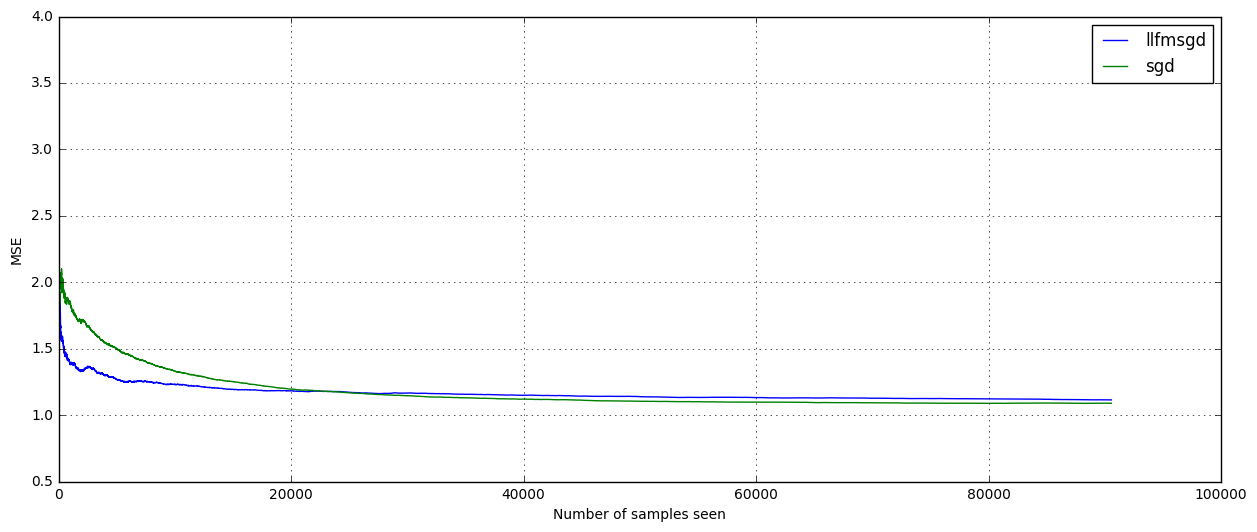

In [38]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(llfm_sgd.mse)
plt.plot(fm_sgd.mse)
plt.legend(['llfmsgd','sgd'])
plt.xlabel('Number of samples seen')
plt.ylabel('MSE')
plt.show()

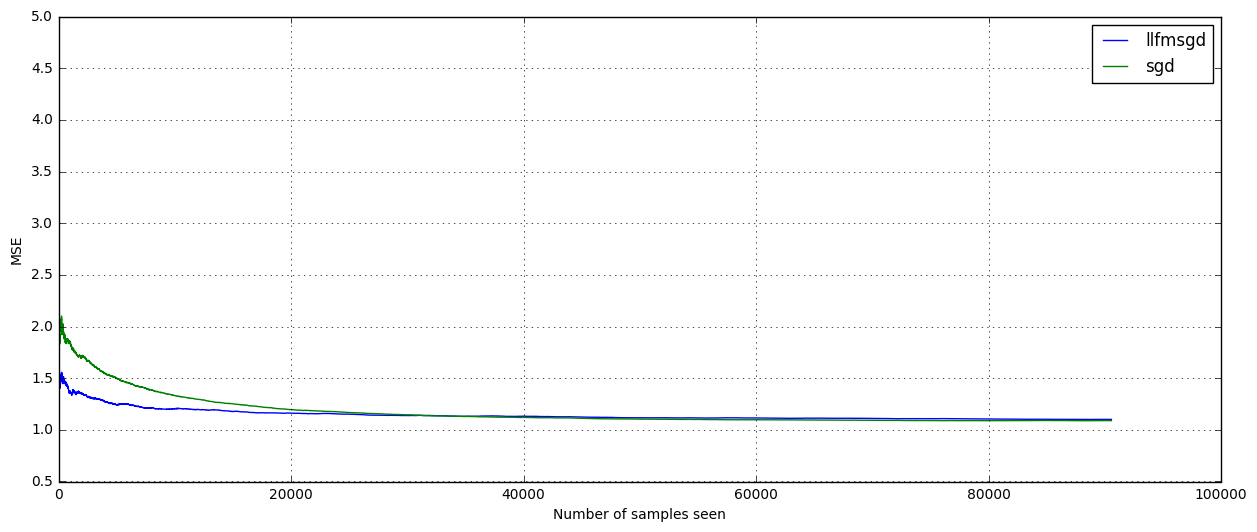

In [84]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.grid(True)
plt.plot(llfm_sgd.mse)
plt.plot(fm_sgd.mse)
plt.legend(['llfmsgd','sgd'])
plt.xlabel('Number of samples seen')
plt.ylabel('MSE')
plt.show()

In [17]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
kmeans = KMeans(n_clusters=100, random_state=0).fit(X_train)

In [18]:
kmeans.inertia_

150969.98689071694

In [19]:
a = np.array([[1,2]])
b = np.array([[2],[1]])

In [21]:
np.dot(a,b).shape

(1L, 1L)

In [28]:
a = np.array([[[1,2]],
              [[3,4]]
             ])

In [29]:
a[0]

array([[1, 2]])

In [1]:
a

NameError: name 'a' is not defined

In [4]:
import numpy as np
a = np.ones((1,2))

In [18]:
b = np.tile(a,(2,1,1))
np.sum(b,axis=2).shape

(2L, 1L)

In [62]:
a = np.array([[1,2],[3,4]])
a**2

array([[ 1,  4],
       [ 9, 16]])